In [8]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
from copy import deepcopy

# Set Parameters

In [9]:
# Stake Weight Multiplier at 2022-09-12
CURRENT_SSWM = 1.4687

# Base stake value of a node in uPOKT
uPOKTbaseStake = 15000000000

# Nodes by bin at 2022-09-12
nodes_by_bin = np.array( [22229, 483, 665, 3944])

# Fairness Values Test
fair_test_list = [0.25, 0.35]
# Give each valu a color for plots
fair_colors = ['green', 'red']


### Define functions

In [10]:

def getPIP22multiplier(nodeStake, 
                      ServicerStakeFloorMultiplier, 
                      ServicerStakeWeightMultiplier, 
                      ServicerStakeWeightCeiling, 
                      ServicerStakeFloorMultiplierExponent, ignore_step = False):
    """

    PIP-22 Multiplier calculation function.

    Parameters:
        nodeStake (float) : Stake of a given node
        ServicerStakeFloorMultiplier (float) : Stake floor of a Pocket node in uPOKT
        ServicerStakeWeightMultiplier (float) : Value of the weight multiplier.
        ServicerStakeWeightCeiling (float) : Maximum (usefull) stake of a Pocket node in uPOKT
        ServicerStakeFloorMultiplierExponent (float) : Multiuplier scaling behaviour value.
    Returns:
        multiplier (float) : The multiplier that is going to be aplied to a node with the given stake amount.

    """

    # Round exponent
    ServicerStakeFloorMultiplierExponent = np.around(ServicerStakeFloorMultiplierExponent, decimals=2)

    # Calculate floored stake of the node
    if ignore_step:
        flooredStake = nodeStake
    else:
        flooredStake = np.min([nodeStake - (nodeStake % ServicerStakeFloorMultiplier), ServicerStakeWeightCeiling])
    # Return the multiplier for this node
    return (flooredStake/ServicerStakeFloorMultiplier)**(ServicerStakeFloorMultiplierExponent)/(ServicerStakeWeightMultiplier)


def get_linear_parameters(nodes_by_bin, uPOKTbaseStake):
    """

    Linear Stake Weighting Parameter calculation function.

    Parameters:
        nodes_by_bin (array) : Number of nodes in each stake bin.
        uPOKTbaseStake (int) : Stake floor of a Pocket node in uPOKT
    Returns:
        parameters (array) : The SSW parameters:
                            - ServicerStakeFloorMultiplier
                            - ServicerStakeWeightMultiplier
                            - ServicerStakeWeightCeiling
                            - ServicerStakeFloorMultiplierExponent

    """

    # Number of staked nodes, regardless stake value
    nodesCompound = nodes_by_bin.sum()
    # Number of nodes in base stake
    nodesBase = 0
    for idx, nodes_here in enumerate(nodes_by_bin):
        nodesBase += nodes_here*(idx+1)
    
    # Get multiplier
    ServicerStakeWeightMultiplier =  nodesBase/nodesCompound
    return  (uPOKTbaseStake, ServicerStakeWeightMultiplier, uPOKTbaseStake*len(nodes_by_bin), 1.)



def get_non_linear_parameters(nodes_by_bin, uPOKTbaseStake, k_fair):
    """

    Non-Linear Stake Weighting Parameter calculation function.

    Parameters:
        nodes_by_bin (array) : Number of nodes in each stake bin.
        uPOKTbaseStake (int) : Stake floor of a Pocket node in uPOKT
        k_fair (float) : Fairness constant.
    Returns:
        parameters (array) : The SSW parameters:
                            - ServicerStakeFloorMultiplier
                            - ServicerStakeWeightMultiplier
                            - ServicerStakeWeightCeiling
                            - ServicerStakeFloorMultiplierExponent
        error (float) : Approximation error

    """

    # Number of staked nodes, regardless stake value
    nodesCompound = nodes_by_bin.sum()

    # Get linear parameters
    (ServicerStakeFloorMultiplier_linear, 
    ServicerStakeWeightMultiplier_linear, 
    ServicerStakeWeightCeiling_linear, 
    ServicerStakeFloorMultiplierExponent_linear) = get_linear_parameters(nodes_by_bin, uPOKTbaseStake)

    # Get multiplier of base bin
    mult = getPIP22multiplier(ServicerStakeFloorMultiplier_linear, 
                      ServicerStakeFloorMultiplier_linear, 
                      ServicerStakeWeightMultiplier_linear, 
                      ServicerStakeWeightCeiling_linear, 
                      ServicerStakeFloorMultiplierExponent_linear)

    # The increase of session does not explain the increase in relays, there is no 
    # evident trend in the correct relation between sessions and relays. 
    # We propose to divide the cost of compounding, setting the multiplier of the 
    # first bin in the middle ground between 1 and the linear multiplier.
    # mult_base_stake = ((1.0-mults[0])/4)+mults[0]
    mult_base_stake = (1-mult)*k_fair + mult

    # Lets get the new base multiplier, using the previous value
    # mult_base_stake = (flooredStake/ServicerStakeFloorMultiplier)**(ServicerStakeFloorMultiplierExponent)/(ServicerStakeWeightMultiplier)
    # with flooredStake == ServicerStakeFloorMultiplier:
    # mult_base_stake = (1.0)**(ServicerStakeFloorMultiplierExponent)/(ServicerStakeWeightMultiplier)
    # knowing that 1^x = 1
    # mult_base_stake = 1.0/(ServicerStakeWeightMultiplier)
    # Then:
    ServicerStakeWeightMultiplierPROPOSED = 1./mult_base_stake


    # Quickly search for a ServicerStakeFloorMultiplierExponent value (not fancy)
    bestFit = 1.0
    bestError = 9e99
    for value in np.linspace(1.0, 0.25, 10000):
        
        # Get this multipliers
        mults = np.zeros((4))
        for i in range(4):
            stake = (i+1)*uPOKTbaseStake
            mult = getPIP22multiplier(stake, 
                                uPOKTbaseStake, 
                                ServicerStakeWeightMultiplierPROPOSED, 
                                uPOKTbaseStake*4, 
                                value)
            mults[i] = mult
        
        # Calculate the error against the unity (see equation 9 of the report)
        error = np.abs(1-(np.array(nodes_by_bin*mults)).sum()/nodesCompound)
        # Keep lowers error
        if error < bestError:
            bestFit = value
            bestError = error

    return  (uPOKTbaseStake, ServicerStakeWeightMultiplierPROPOSED, uPOKTbaseStake*len(nodes_by_bin), bestFit), bestError

# Process

### Get Parameter for each scenario

- Linear with calculated parameters
- Linear with current parameters
- Non linear for the different fairness values

In [11]:
# PUP-21 parameters:
PUP21values = get_linear_parameters(nodes_by_bin, uPOKTbaseStake)

print('PUP-21 Parameters')
print(PUP21values)
print('PUP-21 multipliers:')
settingsUSE = PUP21values
mults = list()
for i in range(4):
    stake = (i+1)*uPOKTbaseStake
    mult = getPIP22multiplier(stake, 
                        settingsUSE[0], 
                        settingsUSE[1], 
                        settingsUSE[2], 
                        settingsUSE[3])
    print('%d kPOKT -> %0.2f'%(stake/1e9, mult))
    mults.append(mult)


PUP-21 Parameters
(15000000000, 1.4994326708392811, 60000000000, 1.0)
PUP-21 multipliers:
15 kPOKT -> 0.67
30 kPOKT -> 1.33
45 kPOKT -> 2.00
60 kPOKT -> 2.67


In [12]:
# Current parameters:
current_values = (uPOKTbaseStake, CURRENT_SSWM, uPOKTbaseStake*4, 1.)
print('Currently Enforced Parameters')
print(current_values)
print('Currently Enforced Multipliers:')
settingsUSE = current_values
mults = list()
for i in range(4):
    stake = (i+1)*uPOKTbaseStake
    mult = getPIP22multiplier(stake, 
                        settingsUSE[0], 
                        settingsUSE[1], 
                        settingsUSE[2], 
                        settingsUSE[3])
    print('%d kPOKT -> %0.4f'%(stake/1e9, mult))
    mults.append(mult)
mults_current = mults

Currently Enforced Parameters
(15000000000, 1.4687, 60000000000, 1.0)
Currently Enforced Multipliers:
15 kPOKT -> 0.6809
30 kPOKT -> 1.3617
45 kPOKT -> 2.0426
60 kPOKT -> 2.7235


In [14]:
print('Non-Linear Stake Weighting')
print('------------------------------')
for K_FAIR in fair_test_list:


    print('Fairness Values : %f' % K_FAIR)
    PROPOSEDvalues, bestError = get_non_linear_parameters(nodes_by_bin, uPOKTbaseStake, K_FAIR)

    # Porposed values, non-linear
    print('error: %0.2f POKT'%(bestError*100.))
    print('Proposed Parameters')
    print(PROPOSEDvalues)

    print('\nProposed multipliers:')
    settingsUSE = PROPOSEDvalues
    for i in range(4):
        stake = (i+1)*uPOKTbaseStake
        mult = getPIP22multiplier(stake, 
                            settingsUSE[0], 
                            settingsUSE[1], 
                            settingsUSE[2], 
                            settingsUSE[3])
        print('%d kPOKT -> %0.4f (%0.4f %%)'%(stake/1e9, mult, ((mult-mults_current[i])*100/mults_current[i])))



    print('------------------------------')

Non-Linear Stake Weighting
------------------------------
Fairness Values : 0.250000
error: 0.06 POKT
Proposed Parameters
(15000000000, 1.3329970958846162, 60000000000, 0.7949294929492949)

Proposed multipliers:
15 kPOKT -> 0.7502 (10.1803 %)
30 kPOKT -> 1.2971 (-4.7450 %)
45 kPOKT -> 1.7869 (-12.5201 %)
60 kPOKT -> 2.2428 (-17.6485 %)
------------------------------
Fairness Values : 0.350000
error: 0.04 POKT
Proposed Parameters
(15000000000, 1.2763286002476886, 60000000000, 0.704995499549955)

Proposed multipliers:
15 kPOKT -> 0.7835 (15.0722 %)
30 kPOKT -> 1.2728 (-6.5323 %)
45 kPOKT -> 1.6905 (-17.2374 %)
60 kPOKT -> 2.0677 (-24.0806 %)
------------------------------


### Plot Changes in Stake Weighting

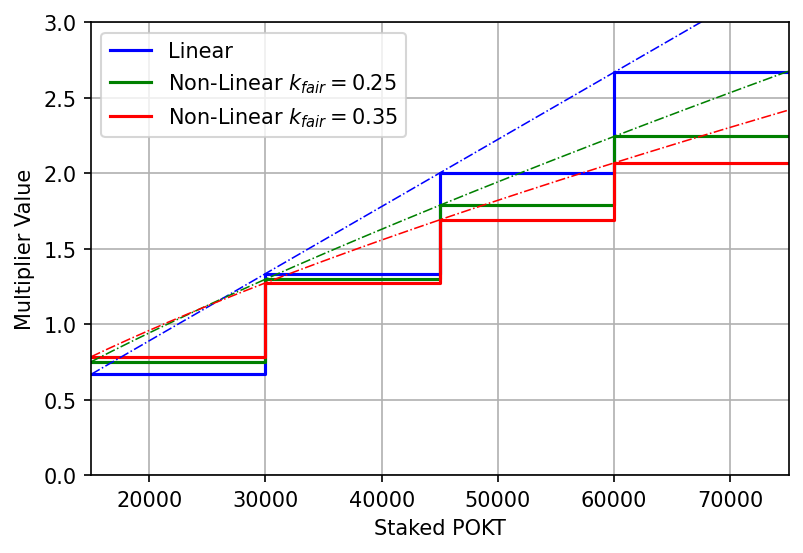

In [ ]:
def plot_stair(settingsUSE, **kwargs):
    mults = list()
    stakes = list()
    for i in range(4):
        stake = (i+1)*uPOKTbaseStake
        mult = getPIP22multiplier(stake, 
                            settingsUSE[0], 
                            settingsUSE[1], 
                            settingsUSE[2], 
                            settingsUSE[3])
        
        stakes.append(stake/1e6)
        mults.append(mult)

        stakes.append((i+2)*uPOKTbaseStake/1e6)
        mults.append(mult)

    plt.plot(stakes,mults, **kwargs)

def plot_continual(settingsUSE, **kwargs):
    mults = list()
    stakes = list()
    for i in np.linspace(0, 5, 1000):
        stake = (i+1)*uPOKTbaseStake
        mult = getPIP22multiplier(stake, 
                            settingsUSE[0], 
                            settingsUSE[1], 
                            settingsUSE[2], 
                            settingsUSE[3],
                            ignore_step=True)
        
        stakes.append(stake/1e6)
        mults.append(mult)


    plt.plot(stakes,mults, **kwargs)

lengend_list = list()
plt.figure(dpi=150)

plot_stair(PUP21values, color='blue')
lengend_list.append('Linear')

for K_FAIR, color in zip(fair_test_list, fair_colors):
    PROPOSEDvalues, bestError = get_non_linear_parameters(nodes_by_bin, uPOKTbaseStake, K_FAIR)
    plot_stair(PROPOSEDvalues, color=color)
    lengend_list.append('Non-Linear '+r'$k_{fair}=%0.2f$'%K_FAIR)

plot_continual(PUP21values, color='blue', linewidth=0.75, linestyle='-.')
for K_FAIR, color in zip(fair_test_list, fair_colors):
    PROPOSEDvalues, bestError = get_non_linear_parameters(nodes_by_bin, uPOKTbaseStake, K_FAIR)
    plot_continual(PROPOSEDvalues, color=color, linewidth=0.75, linestyle='-.')



plt.legend(lengend_list)
plt.ylim(0,3)
plt.xlim(uPOKTbaseStake/1e6,uPOKTbaseStake*5/1e6)
plt.grid()
plt.ylabel('Multiplier Value')
plt.xlabel('Staked POKT')
plt.show()


### Analyze Stake Strategy Changes

In [ ]:
# Amount of uPOKT to stake for each node runner
total_stake = uPOKTbaseStake*12
# Base performance in relays by node by day
base_perf = 32e3
# Relays to token multiplier to get base POKT minting (no stake weight applied)
relay2token = 1038*0.85
# Proportion of base node rewards that are used to cover hardware cost (fixed value)
rel_cost_base = .85
# Relation of low QoS node to high QoS node in term of relays by node by day
# This value shuld be greater than 1
high_perf_to_low_perf_increase = 1.5
# Fairness value to use
k_fair=0.35

In [ ]:
# Get linear parameters
lin_params = get_linear_parameters(nodes_by_bin, uPOKTbaseStake)
(ServicerStakeFloorMultiplier_linear, 
ServicerStakeWeightMultiplier_linear, 
ServicerStakeWeightCeiling_linear, 
ServicerStakeFloorMultiplierExponent_linear) = lin_params

# Get multiplier of base bin
mult_base = getPIP22multiplier(ServicerStakeFloorMultiplier_linear, 
                    ServicerStakeFloorMultiplier_linear, 
                    ServicerStakeWeightMultiplier_linear, 
                    ServicerStakeWeightCeiling_linear, 
                    ServicerStakeFloorMultiplierExponent_linear)

# Get non-linear parameters for chosen kfair
non_lin_params, _ = get_non_linear_parameters(nodes_by_bin, uPOKTbaseStake, k_fair=k_fair)

# Get high performance relays by node by day
high_perf = base_perf*high_perf_to_low_perf_increase
# Get cost of low QoS node
costo_base = base_perf*relay2token*rel_cost_base*mult_base
# Get cost of high QoS node
costo_high = costo_base

# Set different stake scenarios, note that the total stake was carefully chosen
# to avoid fractional results
config_stake = [[total_stake/uPOKTbaseStake, 0, 0, 0], 
                [0, total_stake/(uPOKTbaseStake*2), 0, 0], 
                [0, 0, total_stake/(uPOKTbaseStake*3), 0], 
                [0, 0, 0, total_stake/(uPOKTbaseStake*4)]]

# Helper function to get net income in uPOKT
def calc_retorno(params, stake, cost, perf):
    mult = getPIP22multiplier(stake, 
                            params[0], 
                            params[1], 
                            params[2], 
                            params[3])            
    return  relay2token*nbin*perf*mult - cost

# Test each scenario in linear and non-linear models
info_list = list()
for config in config_stake:

    # For this config calculate:
    retorno = 0
    retorno_high = 0
    lin_retorno = 0
    lin_retorno_high = 0
    nodes = 0
    stake_track = 0
    for i, nbin in enumerate(config):
        stake = (i+1)*uPOKTbaseStake
        
        retorno += calc_retorno(non_lin_params, stake, (costo_base*nbin), base_perf) 
        retorno_high += calc_retorno(non_lin_params, stake, (costo_high*nbin), high_perf) 

        lin_retorno += calc_retorno(lin_params, stake, (costo_base*nbin), base_perf) 
        lin_retorno_high += calc_retorno(lin_params, stake, (costo_high*nbin), high_perf) 

        nodes += nbin 
        stake_track += stake if nbin != 0 else 0

    info_list.append([nodes, stake_track, lin_retorno*1e-6,retorno*1e-6,lin_retorno_high*1e-6, retorno_high*1e-6])

# Convert to dataframe and show results
info_list_df = pd.DataFrame(info_list, columns=['nodes', 'stake by node', 'low_QoS_lin', 'low_QoS_non_lin', 'high_QoS_lin', 'high_QoS_non_lin'])
info_list_df    
    

,nodes,stake by node,low_QoS_lin,low_QoS_non_lin,high_QoS_lin,high_QoS_non_lin
0,12.0,15000000000,33.893139,73.390268,146.870269,206.115963
1,6.0,30000000000,129.923700,119.582966,242.900830,227.389730
2,4.0,45000000000,161.933887,126.898396,274.911017,222.357780
3,3.0,60000000000,177.938980,127.117324,290.916110,214.683626
